In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sklearn.preprocessing import *
import mpl_toolkits.mplot3d
from sklearn.cluster import KMeans
import ffn as ffn
import empyrical as ep
import ffn as ffn
from sktime.forecasting.model_selection import SlidingWindowSplitter

In [2]:
N_CLOSE_PTS = 24
N_PERC_PTS = 5
DIST_MEASURE = 1
FUTURE_CANDLES = 10
N_CLUSTERS = 100
LOG_RETURN_THRESHOLD = 0.02
CALMAR_RATIO_THRESHOLD = 2

INIT_CAPITAL = 1000
RETURNS_CONSTANT = 2500

ONE_DAY = 4 * 24
first_train_size = 150 * ONE_DAY  # 150 days
second_train_size = 100 * ONE_DAY  # 100 days

train_size = first_train_size + second_train_size
test_size = 10 * ONE_DAY  # 10 days
val_test_horizon = test_size * 2
random_state = 1000000000

In [4]:
# Define a function to calculate the ulcer index
def m_ulcer_index(series):
    drawdown = (series - series.cummax()) / series.cummax()
    squared_average = (drawdown**2).mean()
    return squared_average**0.5


# DIST_MEASURE
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data, n_pips):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]]  # Price
    for curr_point in range(2, n_pips):
        md = 0.0  # Max distance
        md_i = -1  # Max distance index
        insert_index = -1
        # Use a single loop to iterate over all the points
        for i in range(1, len(data) - 1):
            left_adj = bisect.bisect_right(pips_x, i) - 1
            right_adj = left_adj + 1
            # Calculate the distance from the point to the line segment
            d = distance(data, pips_x, pips_y, i, left_adj, right_adj)
            # Update the maximum distance and the insert index
            if d > md:
                md = d
                md_i = i
                insert_index = right_adj
        # Insert the new pip
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])
    return pips_x, pips_y


# Define a helper function to calculate the distance
def distance(data, pips_x, pips_y, i, left_adj, right_adj):
    time_diff = pips_x[right_adj] - pips_x[left_adj]
    price_diff = pips_y[right_adj] - pips_y[left_adj]
    slope = price_diff / time_diff
    intercept = pips_y[left_adj] - pips_x[left_adj] * slope
    dist_funcs = {
        1: lambda x, y: ((pips_x[left_adj] - x) ** 2 + (pips_y[left_adj] - y) ** 2)
        ** 0.5
        + ((pips_x[right_adj] - x) ** 2 + (pips_y[right_adj] - y) ** 2) ** 0.5,
        2: lambda x, y: abs((slope * x + intercept) - y) / (slope**2 + 1) ** 0.5,
        3: lambda x, y: abs((slope * x + intercept) - y),
    }
    return dist_funcs[DIST_MEASURE](i, data[i])


def get_pips_df(sub_df):
    pips_y_list = []
    # loop through the data
    for index in range(N_CLOSE_PTS, len(sub_df)):
        try:
            x_close = sub_df["close"].iloc[index - N_CLOSE_PTS : index].to_numpy()
            pips_x, pips_y = find_pips(x_close, N_PERC_PTS)
            scaled_pips_y = (
                StandardScaler()
                .fit_transform(np.array(pips_y).reshape(-1, 1))
                .reshape(-1)
            )
            pips_y_dict = {f"pip_{i}": scaled_pips_y[i] for i in range(N_PERC_PTS)}
            j = index - 1
            pips_y_dict["year"] = sub_df["year"].iloc[j]
            pips_y_dict["month"] = sub_df["month"].iloc[j]
            pips_y_dict["day_of_week"] = sub_df["day_of_week"].iloc[j]
            pips_y_dict["hour"] = sub_df["hour"].iloc[j]
            pips_y_dict["minute"] = sub_df["minute"].iloc[j]
            pips_y_dict["close"] = sub_df["close"].iloc[j]
            # future features
            pips_y_dict["future_close"] = sub_df["close"].iloc[j + FUTURE_CANDLES]
            pips_y_dict["future_return"] = (
                pips_y_dict["future_close"] - pips_y_dict["close"]
            )
            pips_y_dict["future_log_ratio"] = RETURNS_CONSTANT * np.log(
                pips_y_dict["future_close"] / pips_y_dict["close"]
            )
            pips_y_list.append(pips_y_dict)
        except Exception as e:
            break
    return pd.DataFrame(pips_y_list)


def cluster_and_filter_pips_df(pips_y_df, pips_second_train_df):
    pips_y_df_np = pips_y_df[
        ["pip_0", "pip_1", "pip_2", "pip_3", "pip_4", "day_of_week", "hour", "minute"]
    ].to_numpy()
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=random_state)
    kmeans.fit(pips_y_df_np)
    pips_y_df["k_label"] = kmeans.labels_
    k_label_returns_df = (
        pips_y_df.groupby("k_label")["future_log_ratio"]
        .sum()
        .sort_values(ascending=False)
    )

    pips_second_train_df["k_label"] = kmeans.predict(
        pips_second_train_df[
            [
                "pip_0",
                "pip_1",
                "pip_2",
                "pip_3",
                "pip_4",
                "day_of_week",
                "hour",
                "minute",
            ]
        ].to_numpy()
    )

    best_k_labels_list = []
    for k_label in k_label_returns_df.index:
        pips_y_sub_df = pips_y_df[(pips_y_df["k_label"] == k_label)]
        k_label_cumsum = (
            pips_y_sub_df["future_log_ratio"].cumsum().reset_index(drop=True)
        )
        if k_label_cumsum.iloc[-1] > 0:
            signal = 1
        else:
            signal = 0
            k_label_cumsum = -k_label_cumsum
        # Add a constant value to the series
        k_label_cumsum = k_label_cumsum + INIT_CAPITAL
        if not k_label_cumsum.empty:
            start_k_label_cumsum = k_label_cumsum.iloc[0]
            end_k_label_cumsum = k_label_cumsum.iloc[-1]
        else:
            continue

        annualized_return = (end_k_label_cumsum / start_k_label_cumsum) - 1
        ulcer_index = m_ulcer_index(k_label_cumsum)
        max_drawdown = abs(ffn.calc_max_drawdown(k_label_cumsum)) + 0.001
        calmar_ratio = annualized_return / max_drawdown
        if (
            True
            and calmar_ratio > CALMAR_RATIO_THRESHOLD
            and annualized_return > LOG_RETURN_THRESHOLD
        ):

            pips_second_train_df = pips_second_train_df[
                pips_second_train_df["k_label"] == k_label
            ]
            k_label_cumsum = (
                pips_second_train_df["future_log_ratio"].cumsum().reset_index(drop=True)
            )
            if signal == 0:
                k_label_cumsum = -k_label_cumsum
            # Add a constant value to the series
            k_label_cumsum = k_label_cumsum + INIT_CAPITAL
            
            if not k_label_cumsum.empty:
                start_k_label_cumsum = k_label_cumsum.iloc[0]
                end_k_label_cumsum = k_label_cumsum.iloc[-1]
            else:
                continue
            annualized_return = (end_k_label_cumsum / start_k_label_cumsum) - 1
            ulcer_index = m_ulcer_index(k_label_cumsum)
            max_drawdown = abs(ffn.calc_max_drawdown(k_label_cumsum)) + 0.001
            calmar_ratio = annualized_return / max_drawdown
            if (
                True
                and calmar_ratio > CALMAR_RATIO_THRESHOLD
                and annualized_return > LOG_RETURN_THRESHOLD
            ):
                best_k_labels_list.append(
                    {
                        "signal": signal,
                        "k_label": k_label,
                        "calmar_ratio": calmar_ratio,
                        "ulcer_index": ulcer_index,
                        "annualized_return": annualized_return,
                        "max_drawdown": max_drawdown,
                    }
                )
    return pd.DataFrame(best_k_labels_list), kmeans


def filter_pips_df(pips_y_df, train_best_k_labels_df, kmeans):
    pips_y_df_np = pips_y_df[
        ["pip_0", "pip_1", "pip_2", "pip_3", "pip_4", "day_of_week", "hour", "minute"]
    ].to_numpy()
    pips_y_df["k_label"] = kmeans.predict(pips_y_df_np)

    val_best_k_labels_list = []

    for i in range(len(train_best_k_labels_df)):
        k_label = train_best_k_labels_df.iloc[i]["k_label"]
        signal = train_best_k_labels_df.iloc[i]["signal"]
        pips_y_copy_df = pips_y_df[(pips_y_df["k_label"] == k_label)]
        val_k_label_cumsum = pips_y_copy_df["future_log_ratio"].cumsum()
        val_k_label_cumsum = val_k_label_cumsum.reset_index(drop=True)
        if signal == 0:
            val_k_label_cumsum = -val_k_label_cumsum
        # Add a constant value to the series
        val_k_label_cumsum = val_k_label_cumsum + INIT_CAPITAL

        if not val_k_label_cumsum.empty:
            start_val_k_label_cumsum = val_k_label_cumsum.iloc[0]
            end_val_k_label_cumsum = val_k_label_cumsum.iloc[-1]
        else:
            continue

        annualized_return = (end_val_k_label_cumsum / start_val_k_label_cumsum) - 1
        ulcer_index = m_ulcer_index(val_k_label_cumsum)
        max_drawdown = abs(ffn.calc_max_drawdown(val_k_label_cumsum)) + 0.001
        calmar_ratio = annualized_return / max_drawdown

        val_best_k_labels_list.append(
            {
                "signal": signal,
                "k_label": k_label,
                "calmar_ratio": calmar_ratio,
                "ulcer_index": ulcer_index,
                "annualized_return": annualized_return,
                "max_drawdown": max_drawdown,
            }
        )
    return pd.DataFrame(val_best_k_labels_list)

In [5]:
ohlcv_data = pd.read_csv(
    "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv",
    parse_dates=["time"],
)
ohlcv_data = ohlcv_data.set_index("time")
ohlcv_data["year"] = ohlcv_data.index.year
ohlcv_data["month"] = ohlcv_data.index.month
ohlcv_data["day_of_week"] = ohlcv_data.index.dayofweek
ohlcv_data["hour"] = ohlcv_data.index.hour
ohlcv_data["minute"] = ohlcv_data.index.minute
start_date = "2007-01-01"
end_date = "2015-01-01"
ohlcv_data = ohlcv_data[start_date:end_date]
df = ohlcv_data.copy()

In [6]:
splitter = SlidingWindowSplitter(
    window_length=train_size,
    fh=np.arange(1, val_test_horizon + 1),
    step_length=test_size,
)

return_df_list = []
for i, (train_idx, val_test_idx) in enumerate(splitter.split(df)):
    val_idx = val_test_idx[:test_size]
    test_idx = val_test_idx[test_size:]

    first_train_idx = train_idx[:first_train_size]
    second_train_idx = train_idx[first_train_size:]

    # df_train = df.iloc[train_idx, :]

    df_first_train = df.iloc[first_train_idx, :]
    df_second_train = df.iloc[second_train_idx, :]
    df_val = df.iloc[val_idx, :]
    df_test = df.iloc[test_idx, :]

    # FIRST TRAINING
    pips_first_train_df = get_pips_df(df_first_train)
    ts_scaler = StandardScaler().fit(
        pips_first_train_df[["day_of_week", "hour", "minute"]]
    )
    pips_first_train_df[["day_of_week", "hour", "minute"]] = ts_scaler.transform(
        pips_first_train_df[["day_of_week", "hour", "minute"]]
    )

    pips_second_train_df = get_pips_df(df_second_train)
    pips_second_train_df[["day_of_week", "hour", "minute"]] = ts_scaler.transform(
        pips_second_train_df[["day_of_week", "hour", "minute"]]
    )

    train_best_k_labels_df, kmeans = cluster_and_filter_pips_df(
        pips_first_train_df, pips_second_train_df
    )

    # VALIDATION
    pips_val_df = get_pips_df(df_val)
    pips_val_df[["day_of_week", "hour", "minute"]] = ts_scaler.transform(
        pips_val_df[["day_of_week", "hour", "minute"]]
    )
    val_best_k_labels_df = filter_pips_df(pips_val_df, train_best_k_labels_df, kmeans)

    # ACCEPT OR REJECT THE MODEL
    if val_best_k_labels_df.empty:
        continue
    
    if (
        val_best_k_labels_df["annualized_return"].sum() < 0
        # or val_best_k_labels_df["max_drawdown"].sum() > 0.1
        # or val_best_k_labels_df["calmar_ratio"].mean() < 2
    ):
        continue

    # TESTING
    pips_test_df = get_pips_df(df_test)
    pips_test_df[["day_of_week", "hour", "minute"]] = ts_scaler.transform(
        pips_test_df[["day_of_week", "hour", "minute"]]
    )
    test_best_k_labels_df = filter_pips_df(pips_test_df, val_best_k_labels_df, kmeans)

    # check if val_best_k_labels_df or test_best_k_labels_df is not empty
    if val_best_k_labels_df.empty or test_best_k_labels_df.empty:
        continue

    return_df_list.append(
        {
            "window": i,
            "train_sum_annualized_return": train_best_k_labels_df[
                "annualized_return"
            ].sum(),
            "val_sum_annualized_return": val_best_k_labels_df[
                "annualized_return"
            ].sum(),
            "val_sum_max_drawdown": val_best_k_labels_df["max_drawdown"].sum(),
            "val_avg_calmar_ratio": val_best_k_labels_df["calmar_ratio"].mean(),
            "test_sum_annualized_return": test_best_k_labels_df[
                "annualized_return"
            ].sum(),
            "test_sum_max_drawdown": test_best_k_labels_df["max_drawdown"].sum(),
            "test_avg_calmar_ratio": test_best_k_labels_df["calmar_ratio"].mean(),
        }
    )
    # print(f"Window: {i}")
    # print(test_best_k_labels_df)
    if i >= 50:
        break
    # print(f"Train: {df_train.shape[0]}")
    # print(f"Val: {df_val.shape[0]}")
    # print(f"Test: {df_test.shape[0]}")
    # print()
return_df = pd.DataFrame(return_df_list)

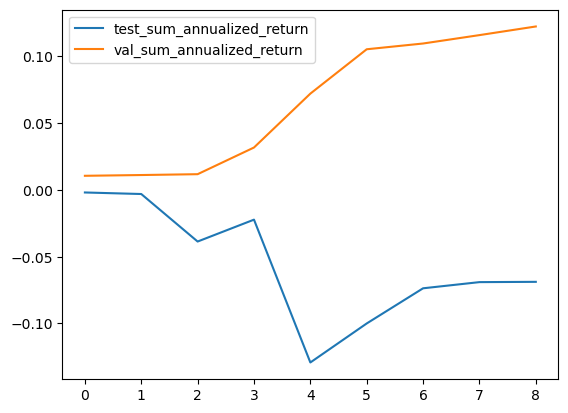

In [7]:
# (return_df["train_sum_annualized_return"]).cumsum().plot()
(return_df["test_sum_annualized_return"]).cumsum().plot()
(return_df['val_sum_annualized_return']).cumsum().plot()
# show legend
plt.legend()
# show graph
plt.show()
# (return_df['test_avg_calmar_ratio']).cumsum().plot()
# (return_df['avg_max_drawdown']).cumsum().plot()

In [ ]:
return_df